In [32]:
import torch
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import os
import sys
import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# --- 로컬 Pororo 모듈 경로 설정 ---
# 이 노트북 파일이 customOCR 폴더에 있다고 가정합니다.
PORORO_PATH = os.path.abspath(os.path.join(os.path.dirname('.'), '..', 'pororo_main'))
if PORORO_PATH not in sys.path:
    sys.path.append(PORORO_PATH)
    print(f"Added to sys.path: {PORORO_PATH}")

try:
    from main import PororoOcr
except ImportError:
    print(f"오류: '{PORORO_PATH}' 경로에서 Pororo 모듈을 찾을 수 없습니다.")
    print("customOCR 폴더와 같은 위치에 'pororo_main' 폴더가 있는지 확인해주세요.")
    raise

print("\n필요한 모듈을 모두 로드했습니다.")


필요한 모듈을 모두 로드했습니다.


In [33]:
class YOLOv8_OCR_Predictor:
    """YOLOv8로 객체를 탐지하고, 탐지된 영역에서 OCR을 수행하는 예측기"""

    def __init__(self, model_path, font_path=None):
        # --- 1. 모델 및 OCR 엔진 로드 ---
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"YOLO 모델 가중치 파일을 찾을 수 없습니다: {model_path}")
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"사용 장치: {self.device.upper()}")

        print("YOLOv8 모델 로딩 중...")
        self.model = YOLO(model_path)
        self.model.to(self.device)
        
        print("Pororo OCR 엔진 초기화 중...")
        self.ocr_reader = PororoOcr()

        # 시각화를 위한 폰트 설정
        try:
            self.font = ImageFont.truetype(font_path or "malgun.ttf", size=15)
        except IOError:
            print("경고: 'malgun.ttf' 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
            self.font = ImageFont.load_default()

    def detect_only(self, image_path, conf_threshold=0.5):
        """[1단계] 이미지에서 객체만 탐지합니다 (OCR 없음)."""
        if not os.path.exists(image_path):
            print(f"오류: 이미지 파일을 찾을 수 없습니다: {image_path}")
            return None, None

        original_image = Image.open(image_path).convert("RGB")
        results = self.model.predict(original_image, conf=conf_threshold, verbose=False)
        
        detected_objects = []
        for res in results:
            boxes = res.boxes.cpu().numpy()
            for box in boxes:
                class_id = int(box.cls[0])
                label = self.model.names[class_id]
                confidence = float(box.conf[0])
                coords = [int(c) for c in box.xyxy[0]]
                
                detected_objects.append({'label': label, 'box': coords, 'confidence': confidence})
        
        detected_objects.sort(key=lambda obj: (obj['box'][1], obj['box'][0]))
        return detected_objects, original_image

    def run_ocr_on_detections(self, original_image, detected_objects):
        """[2단계] 탐지된 객체 리스트에 대해 OCR을 수행합니다."""
        structured_results = []
        for obj in detected_objects:
            box = obj['box']
            box_width = box[2] - box[0]
            box_height = box[3] - box[1]

            if box_width < 5 or box_height < 5:
                text = ""
            else:
                cropped_image = original_image.crop(box)
                temp_crop_path = "temp_cropped_image.png"
                cropped_image.save(temp_crop_path)
                ocr_text_list = self.ocr_reader.run_ocr(temp_crop_path, debug=False)
                text = ' '.join(ocr_text_list) if ocr_text_list else ""
                os.remove(temp_crop_path)

            structured_results.append({
                'label': obj['label'], 'text': text.strip(),
                'box': obj['box'], 'confidence': f"{obj['confidence']:.2f}"
            })
        return structured_results

    def draw_detections(self, image, detections):
        """탐지 결과(박스 + 라벨)만 시각화합니다."""
        draw = ImageDraw.Draw(image)
        label_colors = {
            "DATE_HEADER": "#ff7f0e", "DATE": "#1f77b4", "TIME": "#d62728",
            "MERCHANT": "#2ca02c", "MEMO": "#9467bd", "AMOUNT_IN": "#8c564b",
            "AMOUNT_OUT": "#e377c2", "BALANCE": "#7f7f7f",
        }
        for det in detections:
            box, label, confidence = det['box'], det['label'], det['confidence']
            color = label_colors.get(label, "#bcbd22")
            draw.rectangle(box, outline=color, width=3)
            label_text = f"{label} ({confidence:.2f})"
            text_bbox = draw.textbbox((box[0], box[1]), label_text, font=self.font)
            label_bg_box = [box[0], box[1] - (text_bbox[3] - text_bbox[1]) - 6, box[0] + (text_bbox[2] - text_bbox[0]) + 8, box[1]]
            draw.rectangle(label_bg_box, fill=color)
            draw.text((box[0] + 4, box[1] - (text_bbox[3] - text_bbox[1]) - 4), label_text, fill="white", font=self.font)
        return image

    def draw_predictions(self, image, predictions):
        """최종 예측 결과(박스 + 라벨 + OCR 텍스트)를 시각화합니다."""
        draw = ImageDraw.Draw(image)
        label_colors = {
            "DATE_HEADER": "#ff7f0e", "DATE": "#1f77b4", "TIME": "#d62728",
            "MERCHANT": "#2ca02c", "MEMO": "#9467bd", "AMOUNT_IN": "#8c564b",
            "AMOUNT_OUT": "#e377c2", "BALANCE": "#7f7f7f",
        }
        for pred in predictions:
            box, label, text, confidence = pred['box'], pred['label'], pred['text'], pred['confidence']
            color = label_colors.get(label, "#bcbd22")
            draw.rectangle(box, outline=color, width=3)
            label_text = f"{label}: {text} ({confidence})"
            text_bbox = draw.textbbox((box[0], box[1]), label_text, font=self.font)
            label_bg_box = [box[0], box[1] - (text_bbox[3] - text_bbox[1]) - 6, box[0] + (text_bbox[2] - text_bbox[0]) + 8, box[1]]
            draw.rectangle(label_bg_box, fill=color)
            draw.text((box[0] + 4, box[1] - (text_bbox[3] - text_bbox[1]) - 4), label_text, fill="white", font=self.font)
        return image

print("YOLOv8_OCR_Predictor 클래스가 탐지/OCR 분리 기능으로 업데이트되었습니다.")

YOLOv8_OCR_Predictor 클래스가 탐지/OCR 분리 기능으로 업데이트되었습니다.


In [34]:
# --- 1. 설정 ---
# 학습된 YOLO 모델 가중치 파일 경로
MODEL_PATH = 'C:/code/customOCR/bank_statement_detector/yolov8m_e50_bs8/weights/best.pt'
# 테스트할 이미지가 있는 디렉토리
TEST_IMAGE_DIR = '../bank_statement_test'
TEST_IMAGE_DIR2 = '../bank_statement'
# 예측 결과 이미지를 저장할 디렉토리
OUTPUT_DIR = 'C:/code/customOCR/yolo_predictions'
# 객체 탐지를 위한 신뢰도 임계값
CONF_THRESHOLD = 0.25
# 사용할 폰트 경로 (None으로 두면 시스템 기본 폰트 또는 'malgun.ttf' 시도)
FONT_PATH = None 

# --- 2. 예측기 초기화 ---
try:
    predictor = YOLOv8_OCR_Predictor(model_path=MODEL_PATH, font_path=FONT_PATH)
except Exception as e:
    print(f"예측기 초기화 실패: {e}")
    # Stop execution if predictor fails
    raise

사용 장치: CUDA
YOLOv8 모델 로딩 중...
Pororo OCR 엔진 초기화 중...



--- [1단계: 탐지] sc1.png ---


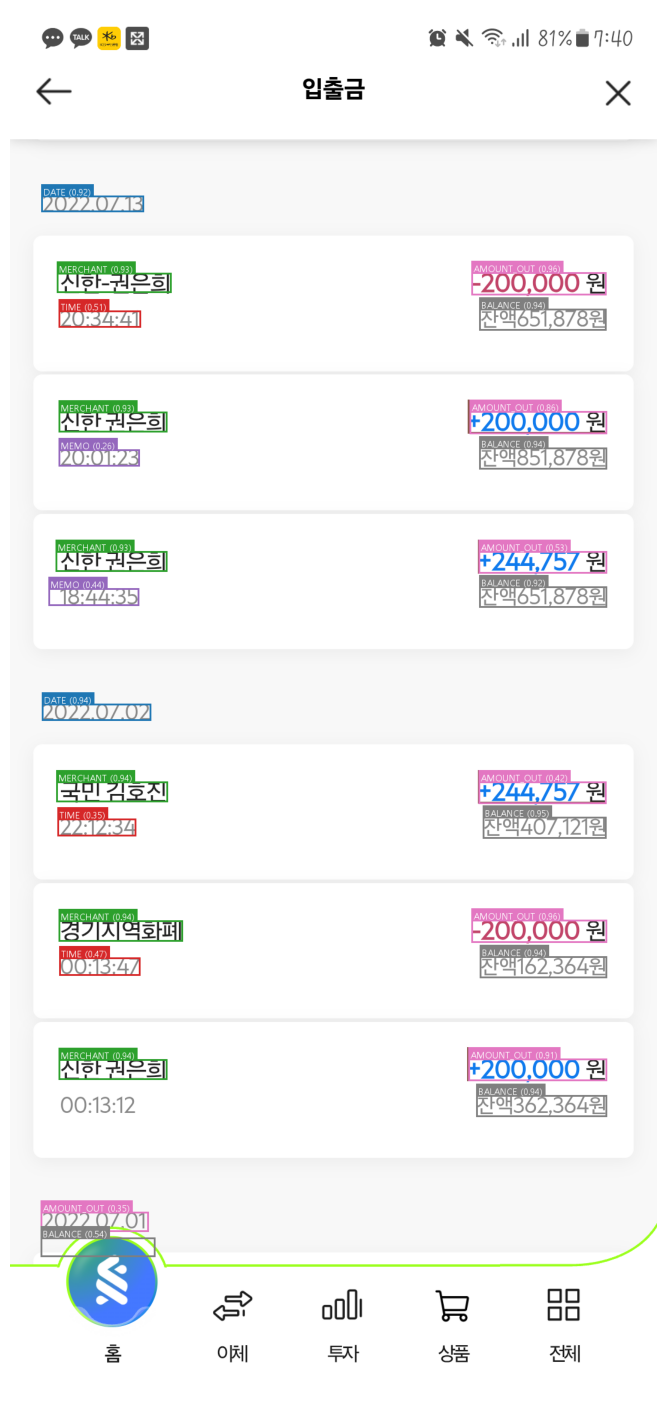


--- [1단계: 탐지] sanup1.jpg ---


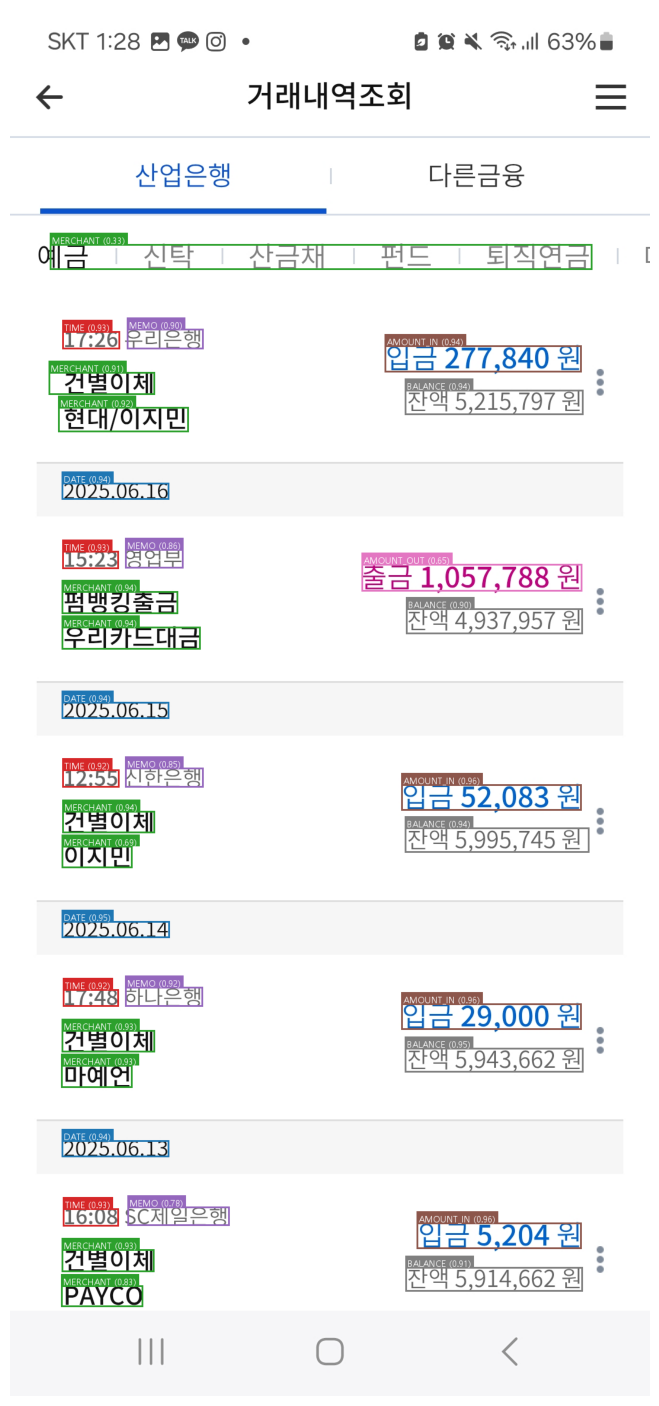


--- [1단계: 탐지] sanup2.jpg ---


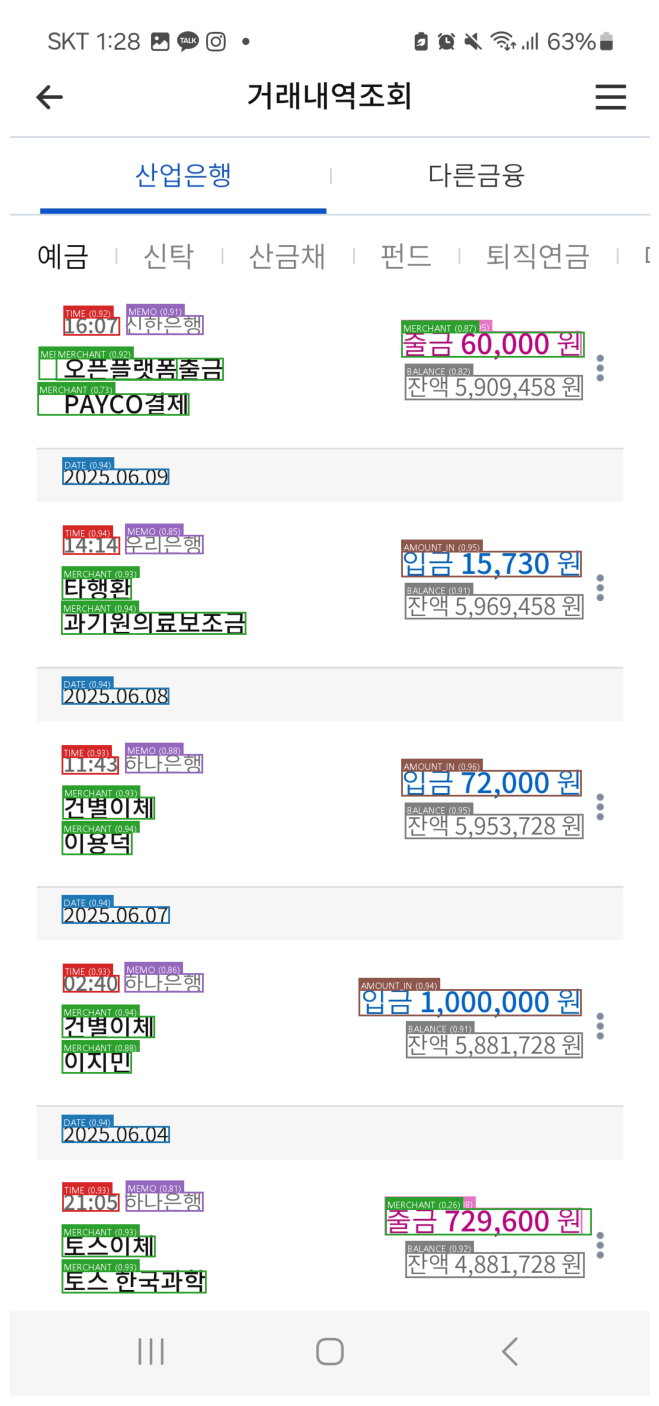


--- [1단계: 탐지] sanup3.jpg ---


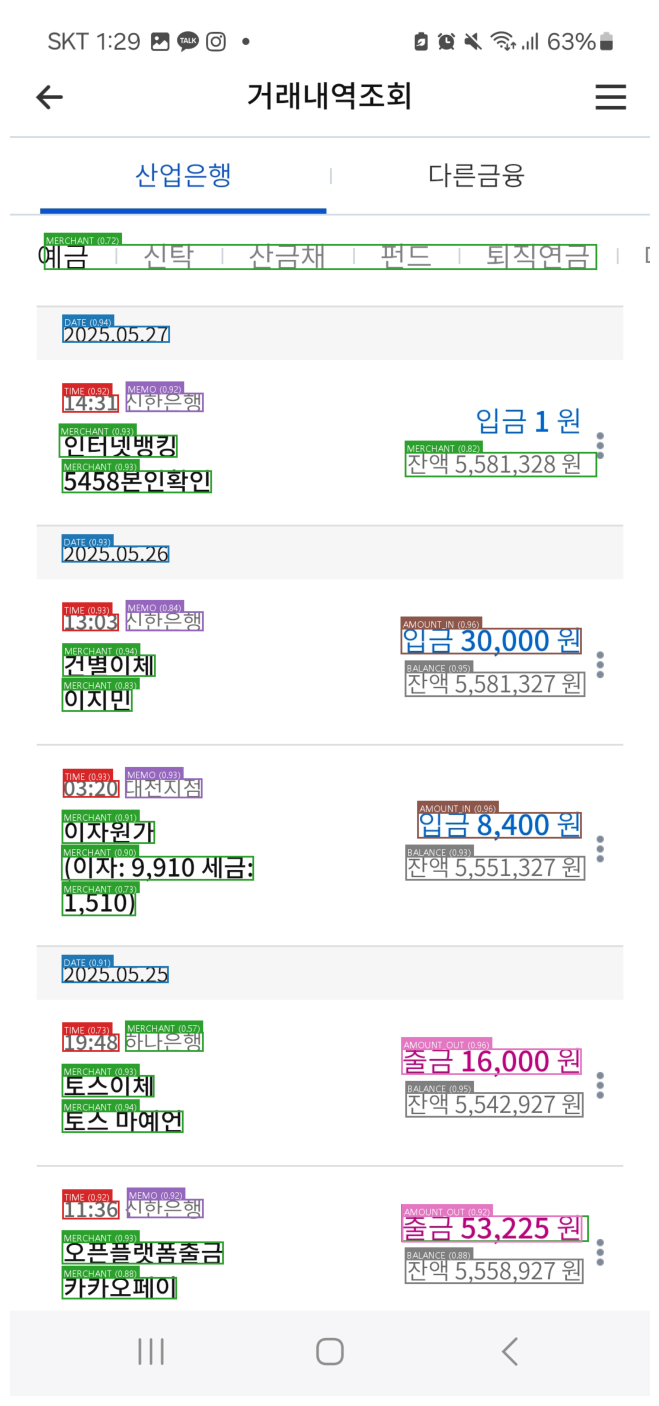


--- [1단계: 탐지] sanup4.jpg ---


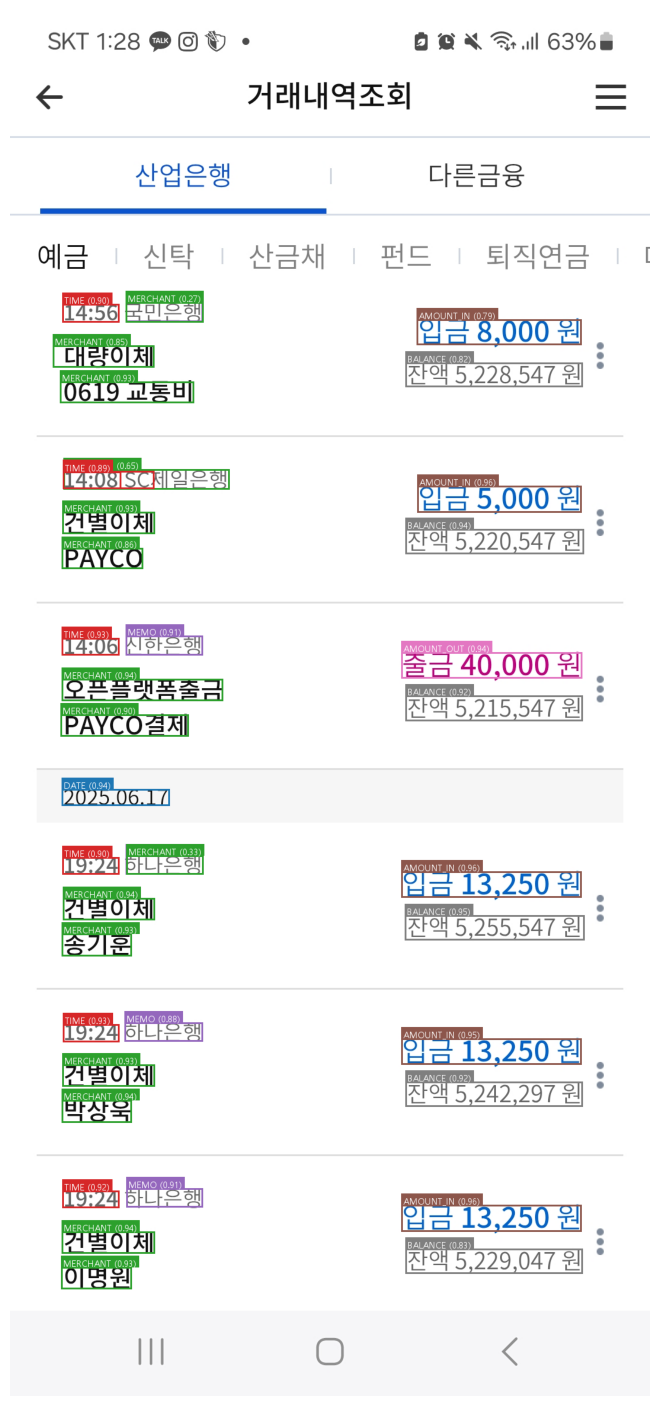


--- [1단계: 탐지] kookmin1.png ---


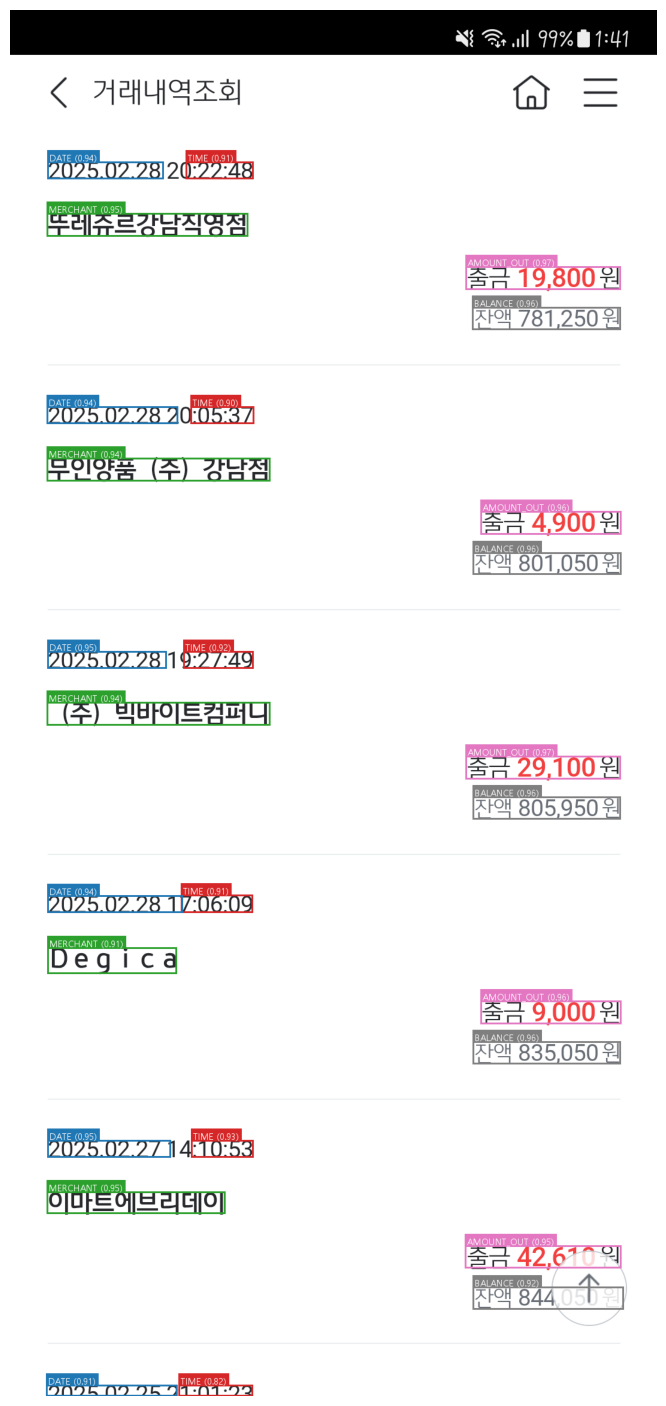


--- [1단계: 탐지] kookmin2.png ---


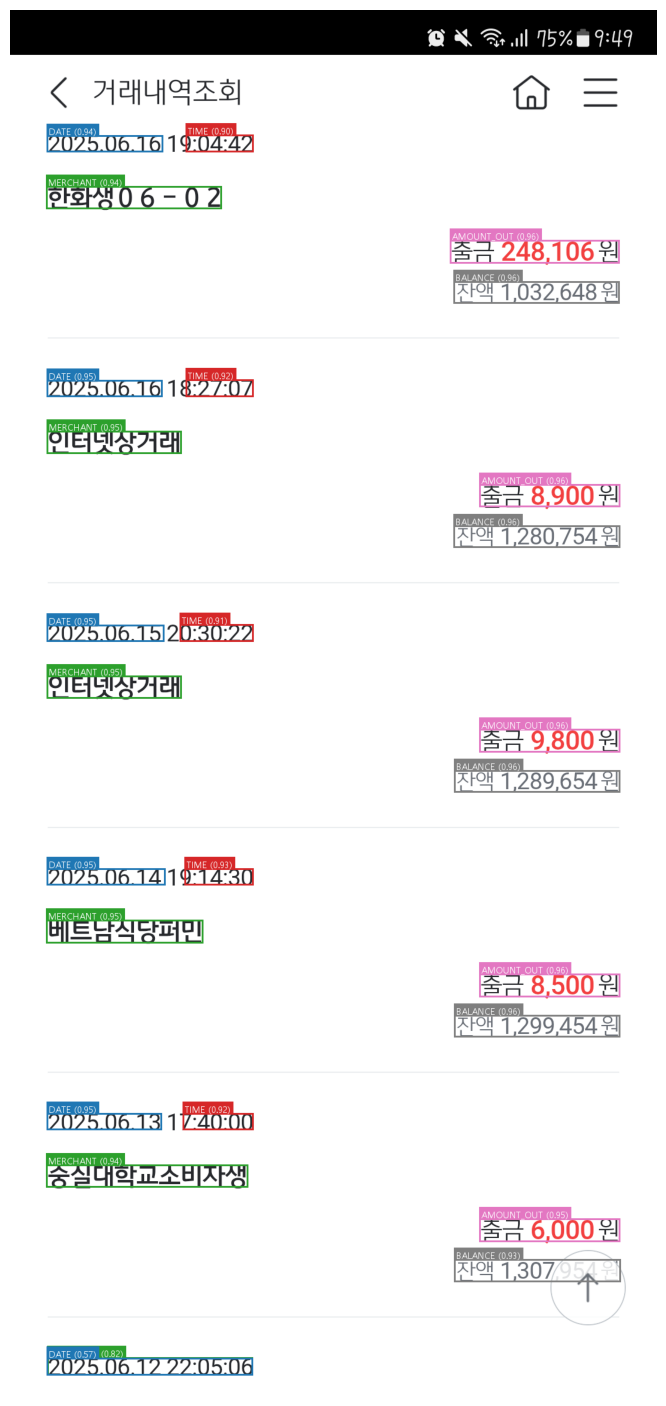


--- [1단계: 탐지] kookmin3.png ---


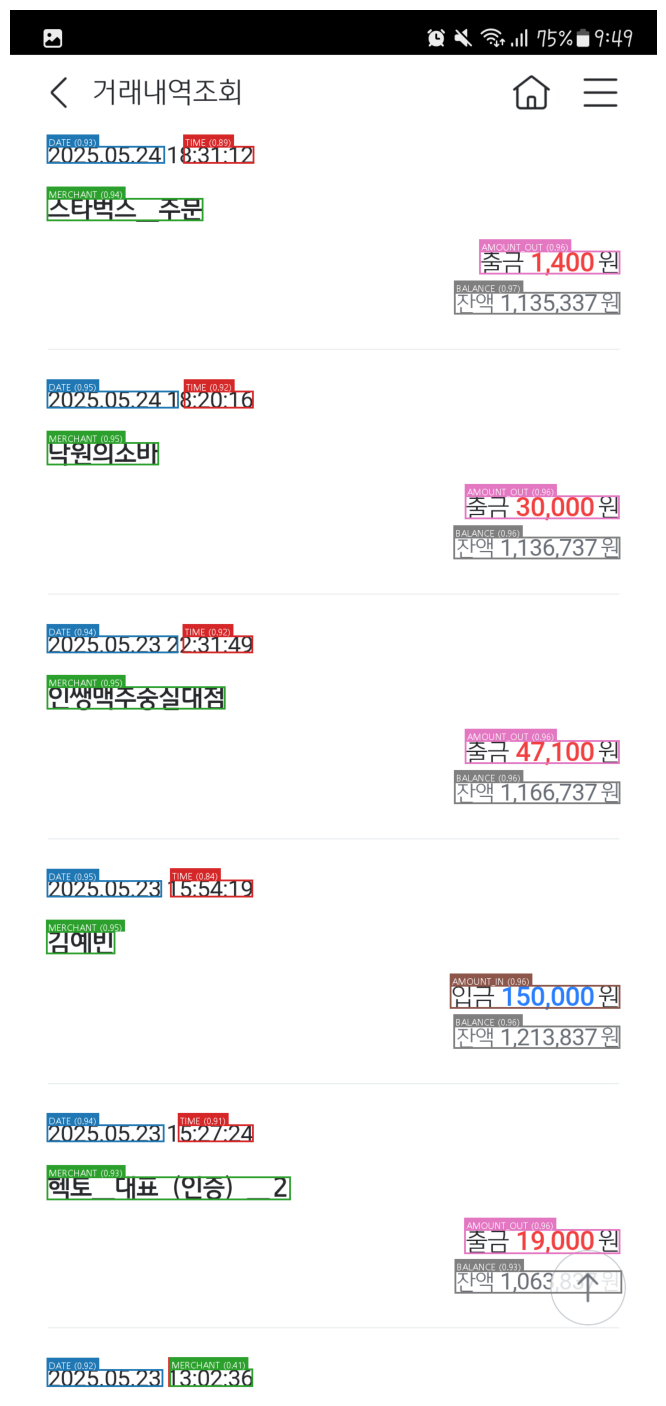


--- [1단계: 탐지] kookmin4.png ---


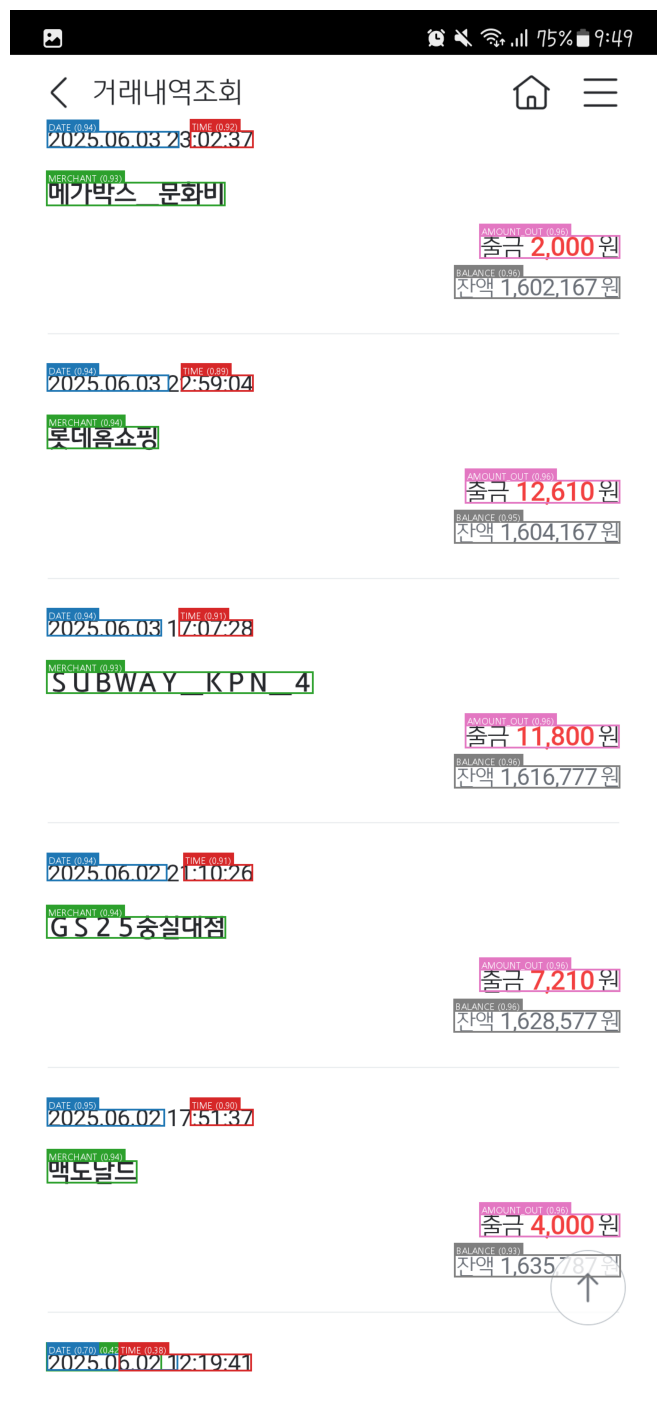


--- [1단계: 탐지] shinhan1.png ---


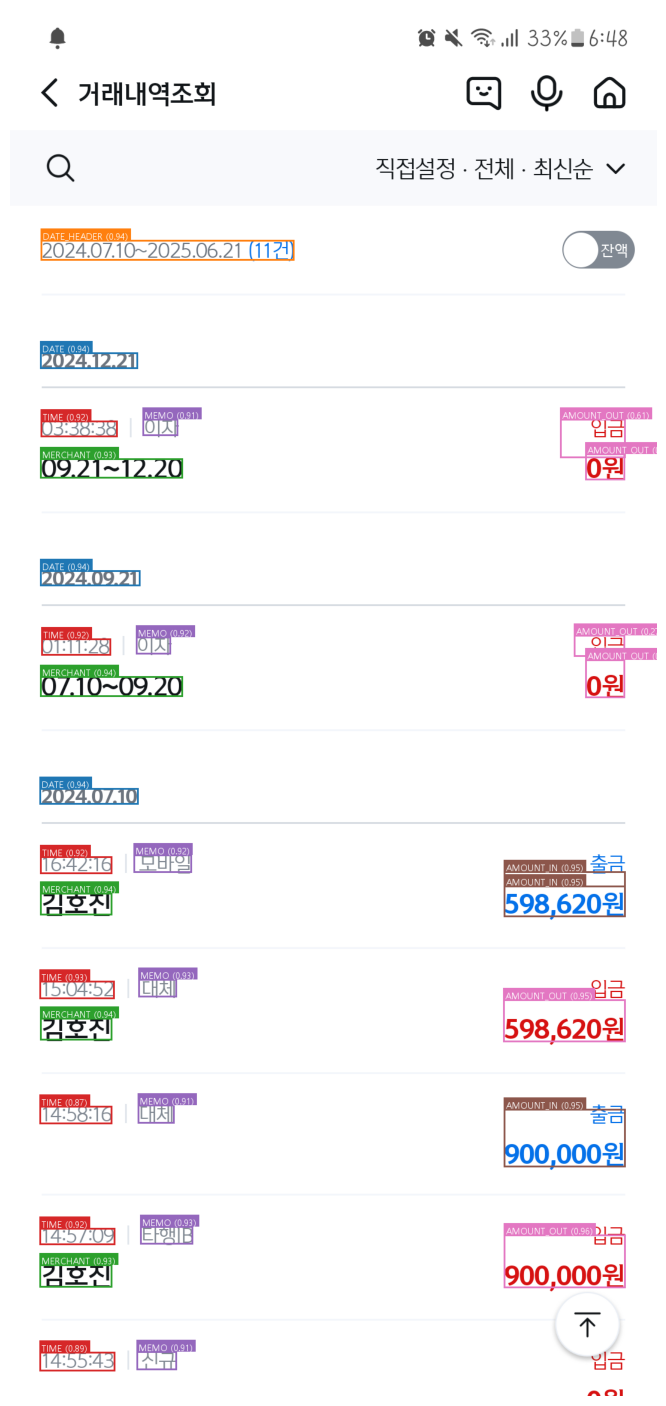


--- [1단계: 탐지] shinhyup.png ---


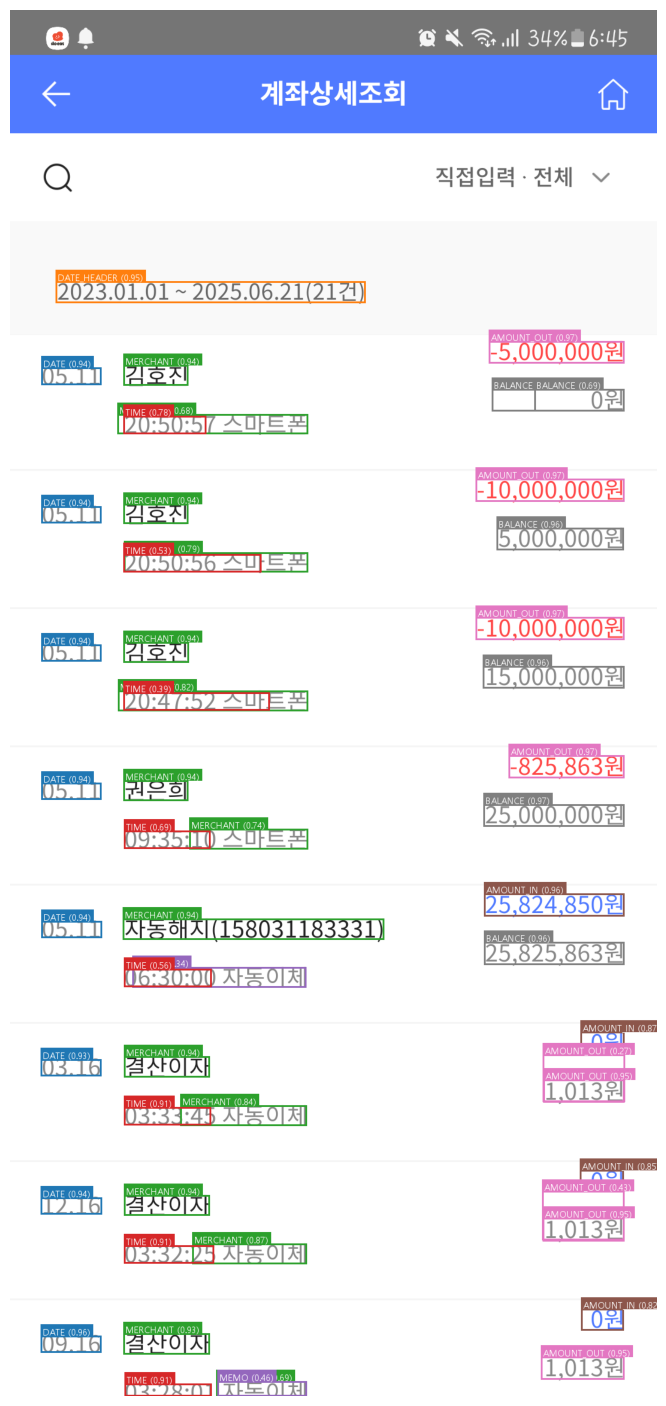


--- [1단계: 탐지] toss1.png ---


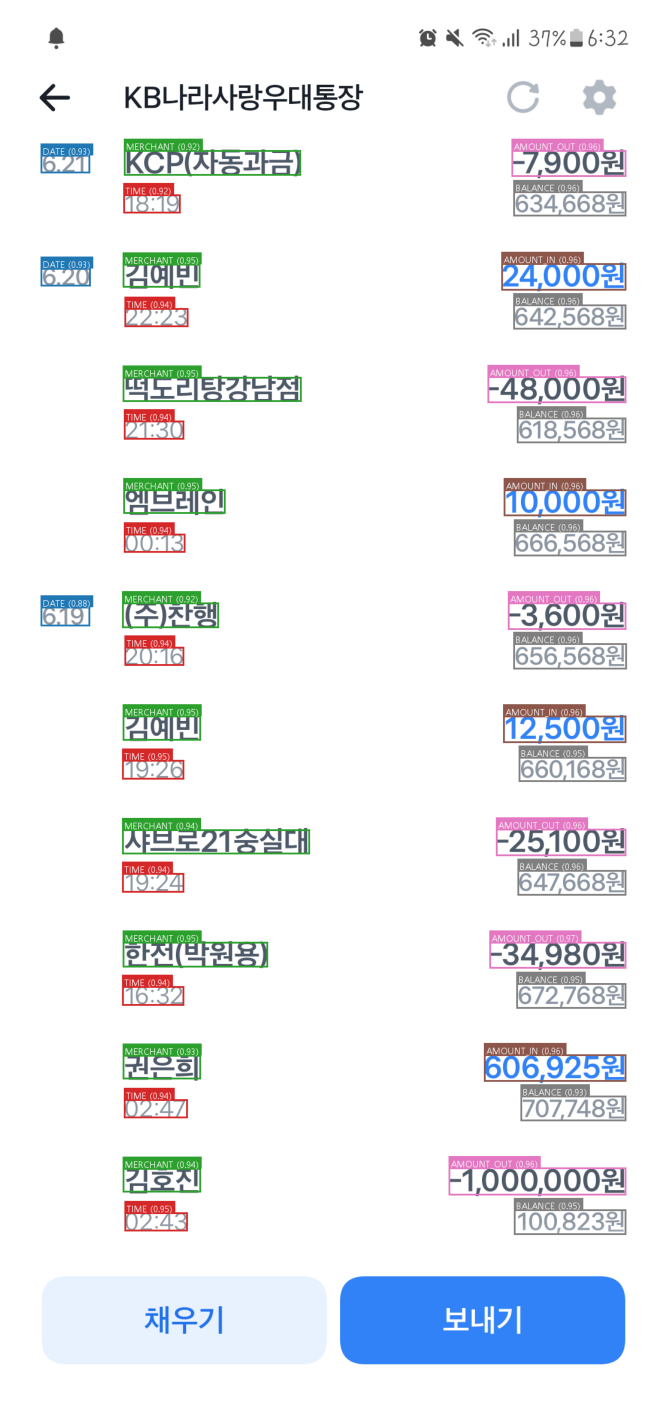


--- [1단계: 탐지] toss2.png ---


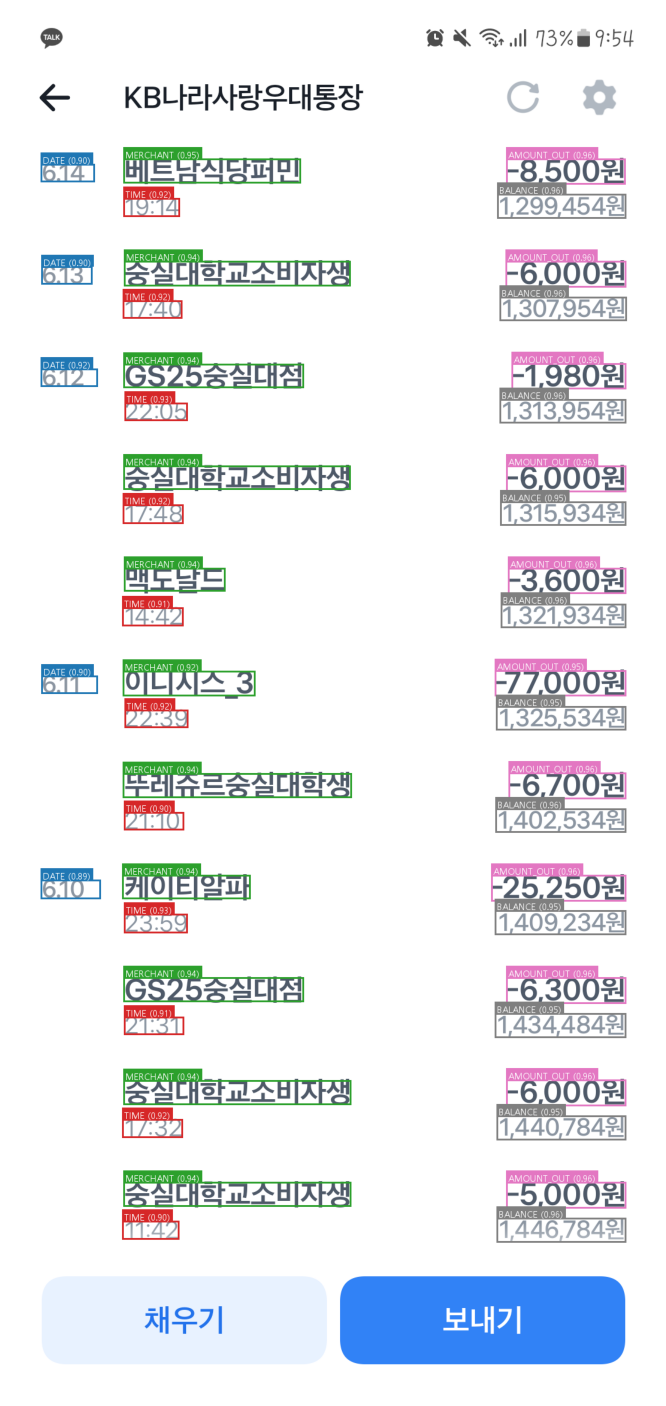


--- [1단계: 탐지] toss3.png ---


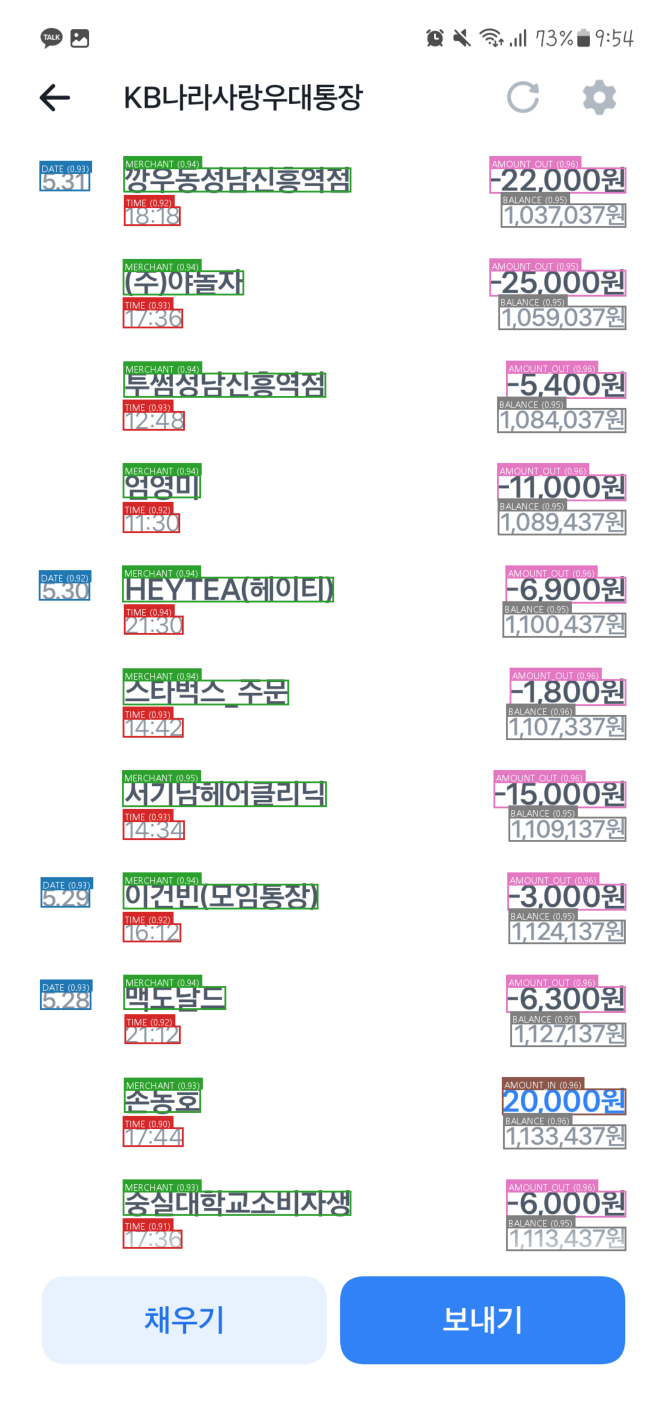


--- [1단계: 탐지] toss4.png ---


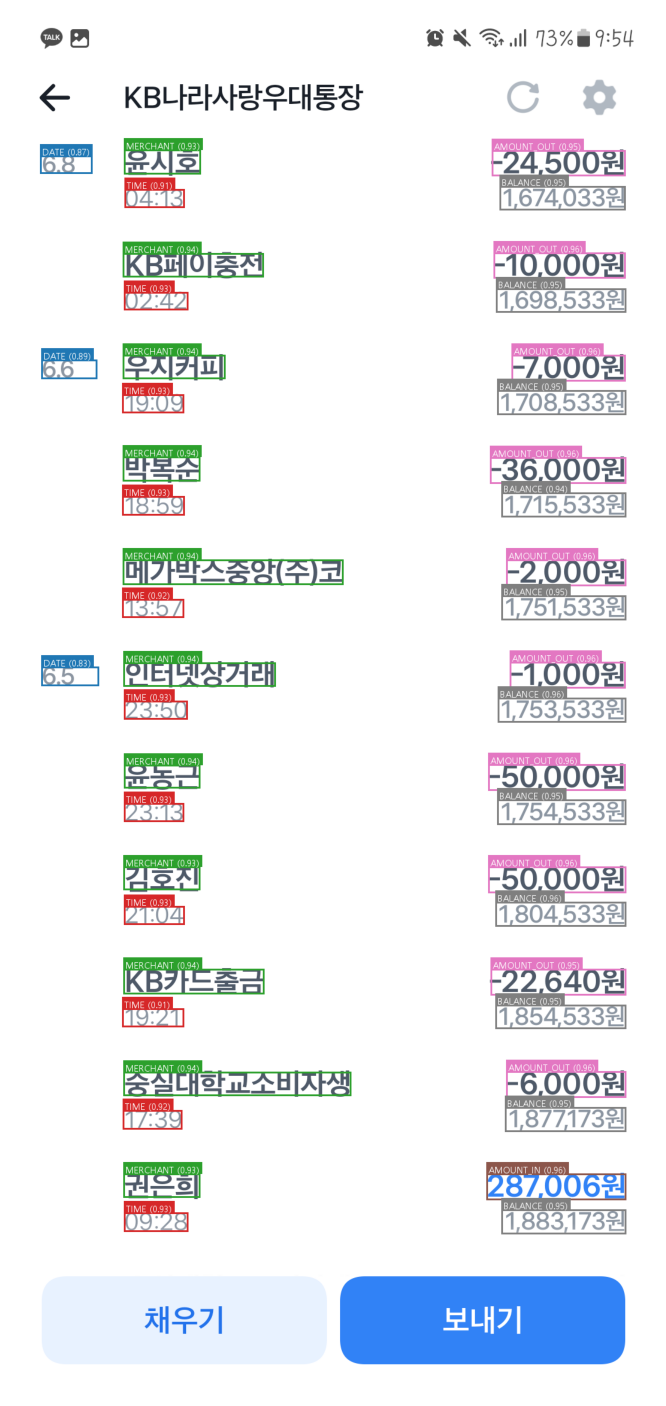


--- [1단계: 탐지] woori1.png ---


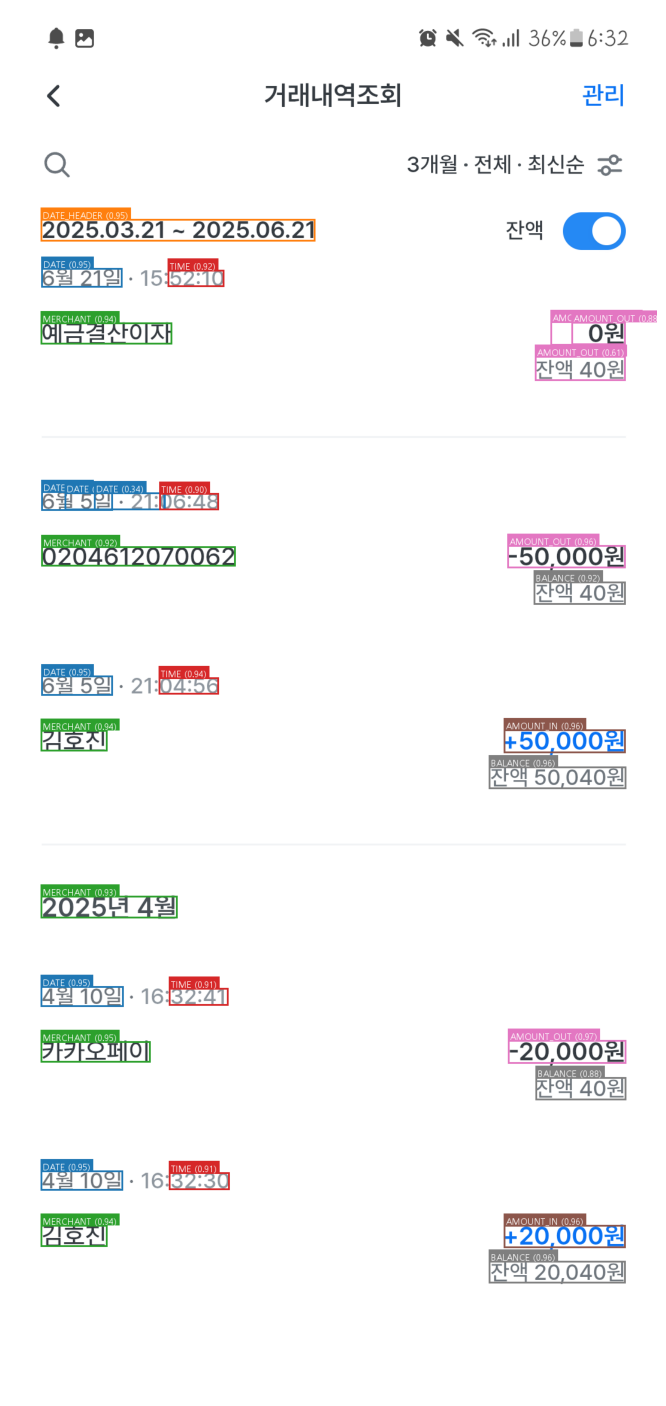


--- [1단계: 탐지] woori2.png ---


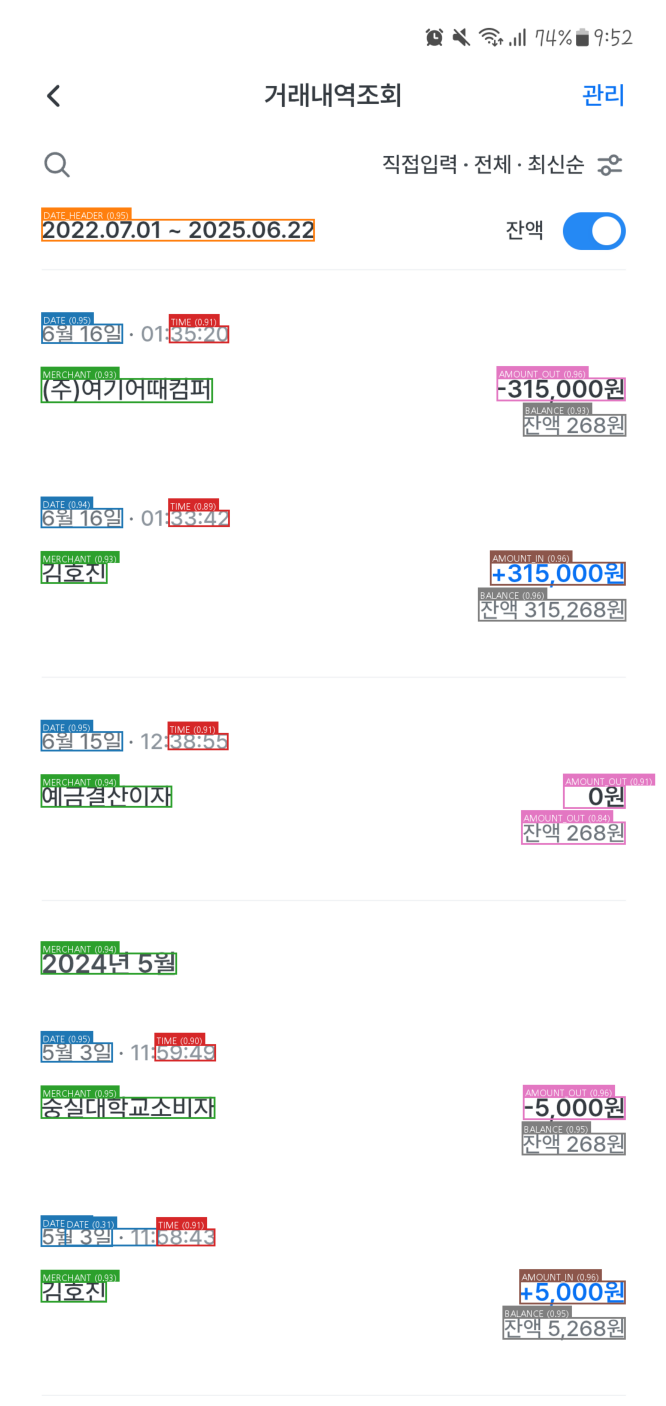


--- [1단계: 탐지] woori3.png ---


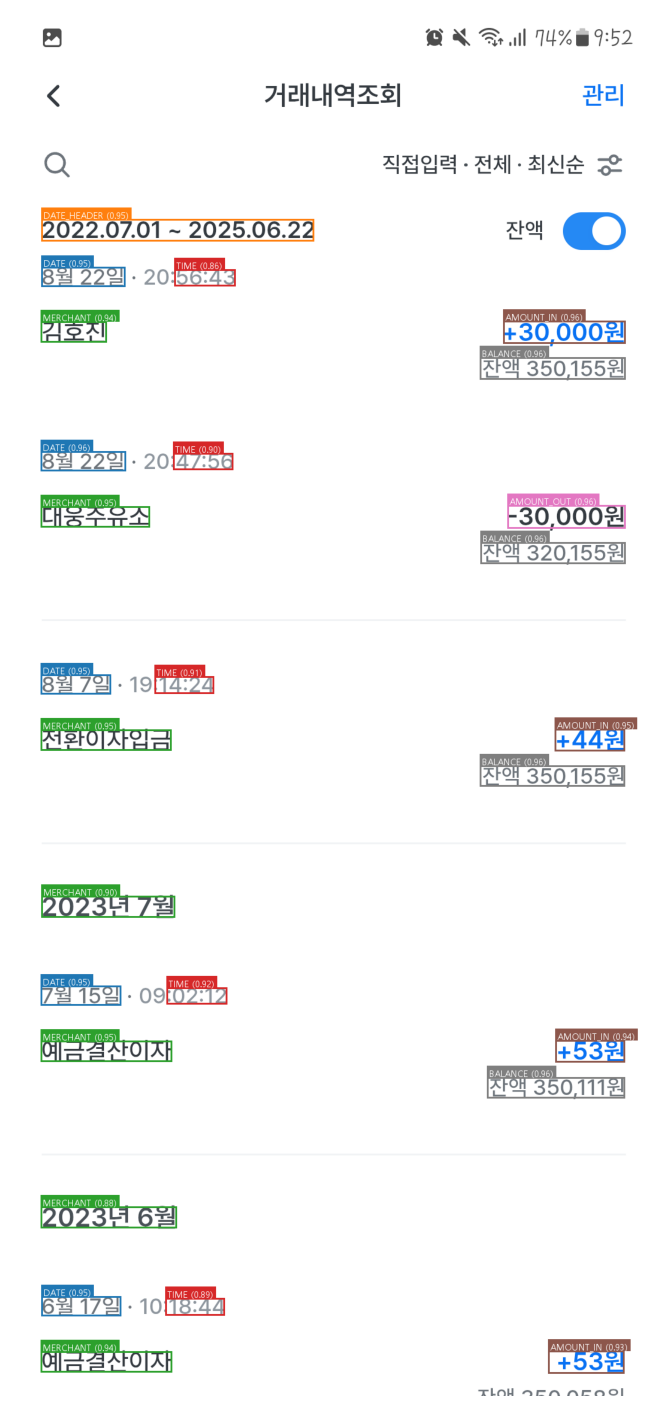


--- [1단계: 탐지] woori4.png ---


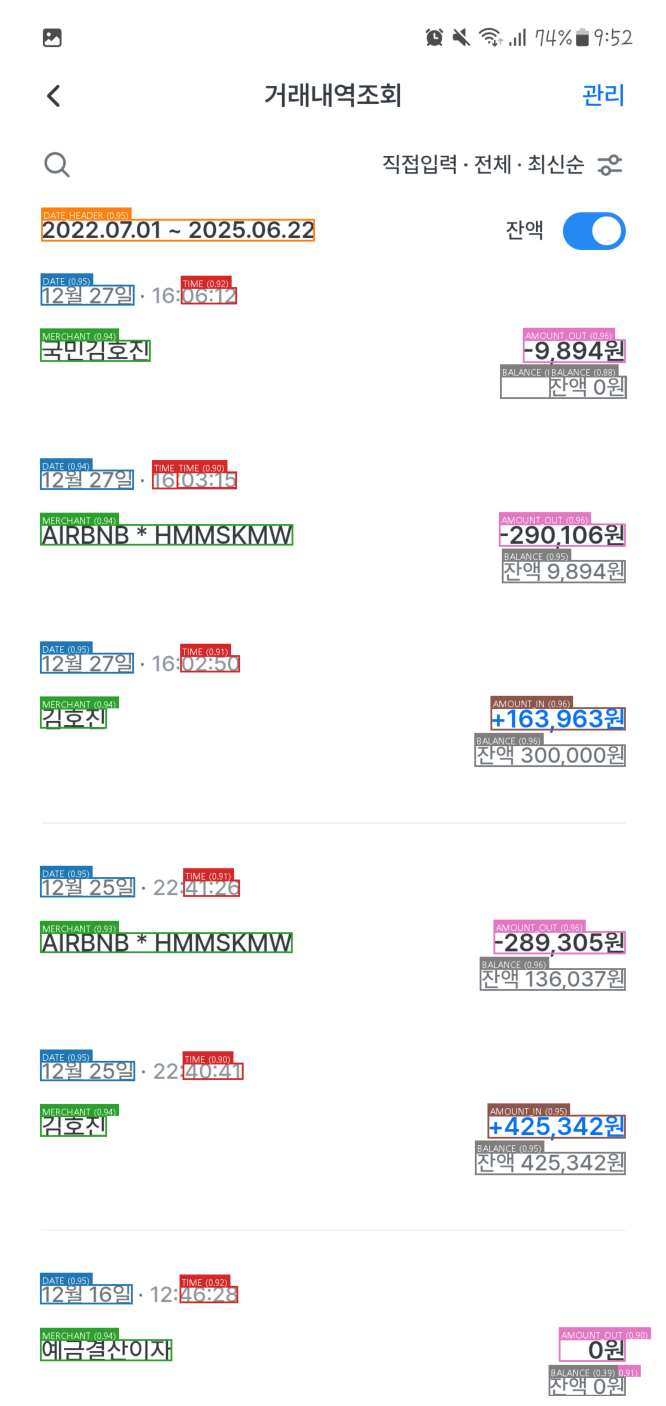


--- [1단계: 탐지] bank_statement_long.jpg ---


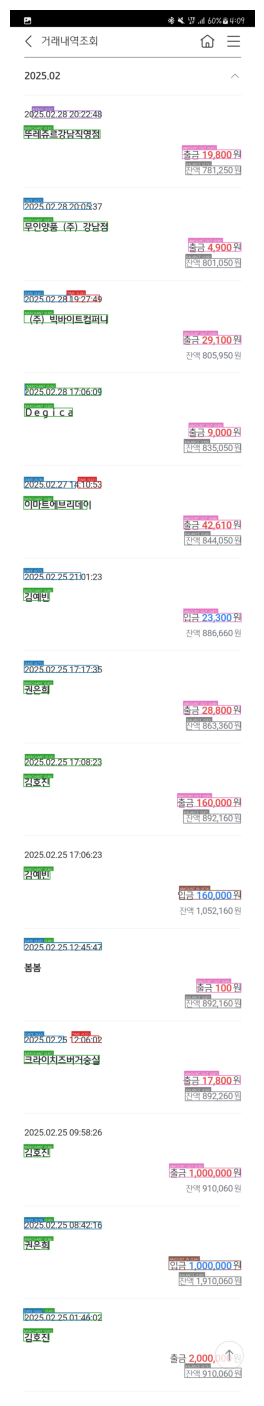


--- [1단계: 탐지] kabang1.jpg ---


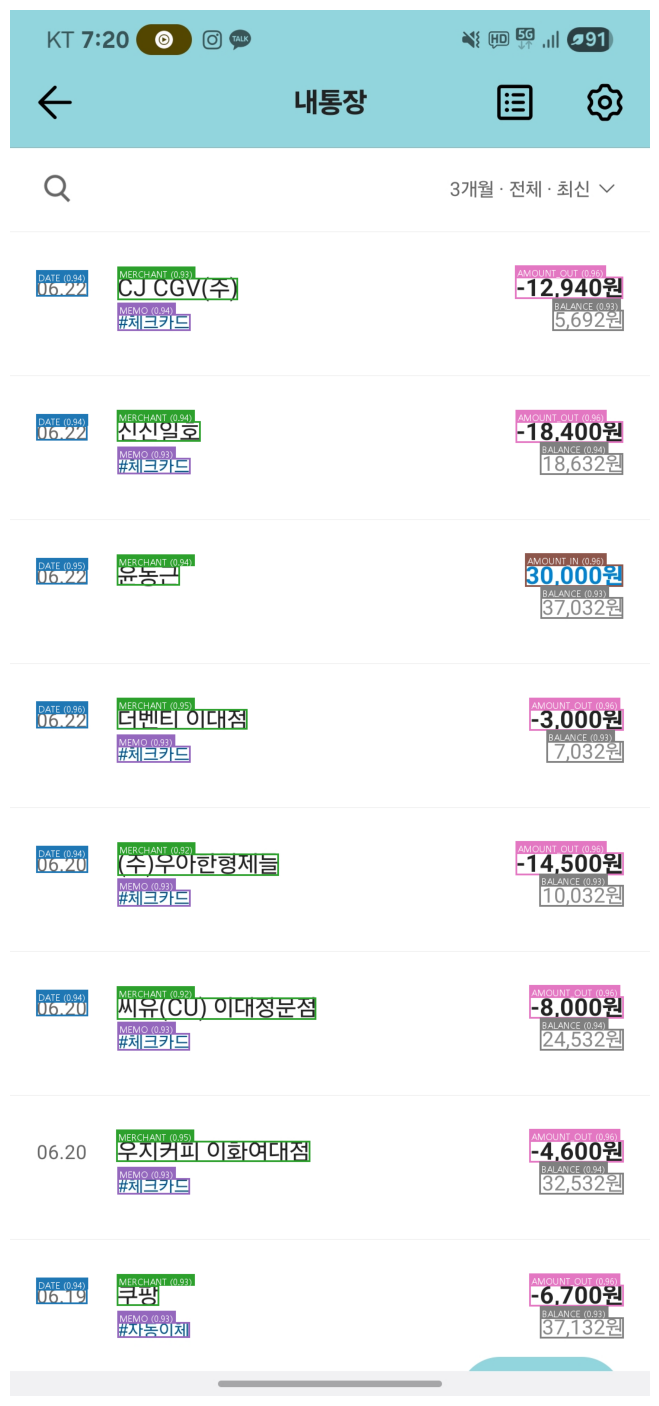


--- [1단계: 탐지] kabang2.jpg ---


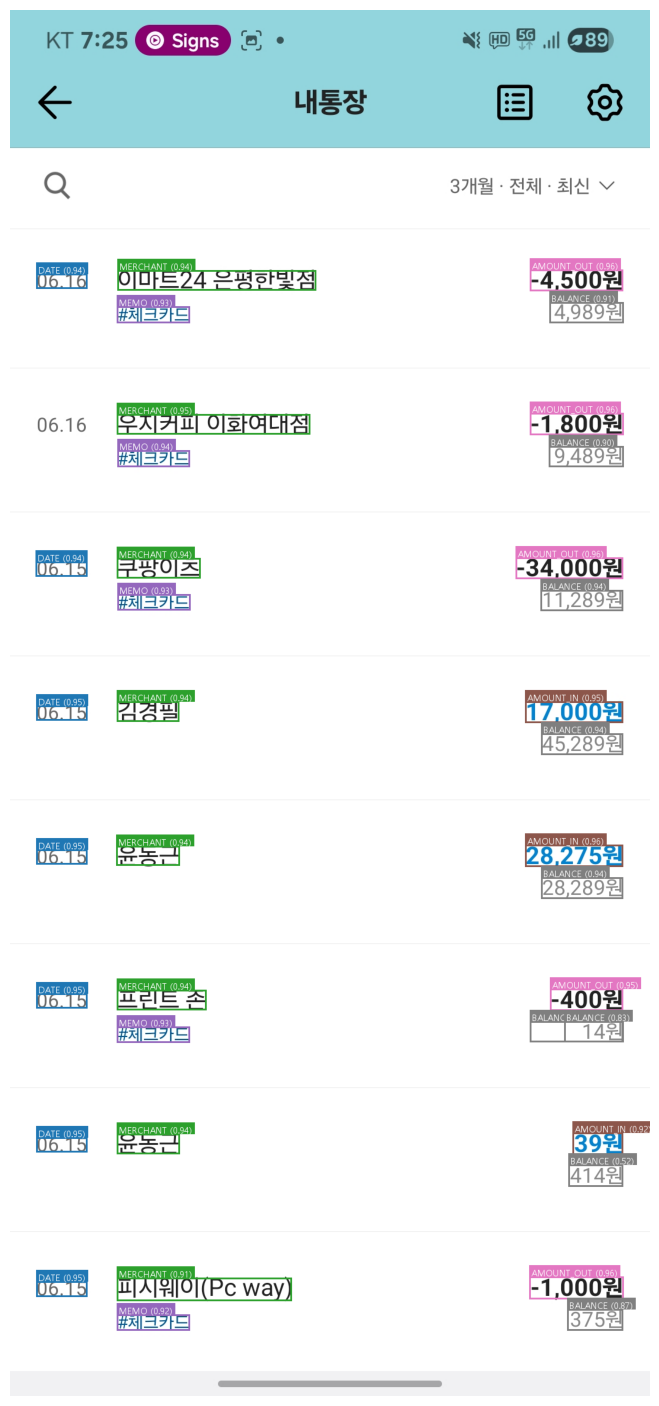


--- [1단계: 탐지] kabang3.jpg ---


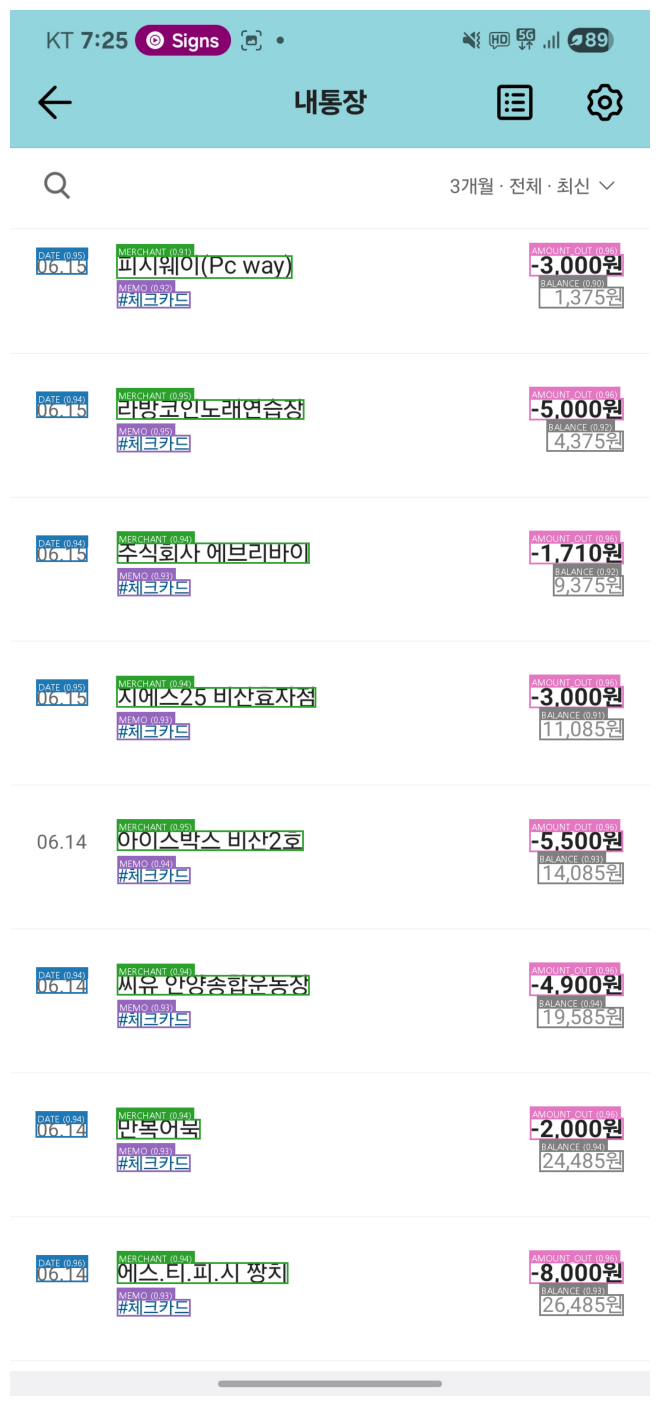


--- [1단계: 탐지] kabang4.jpg ---


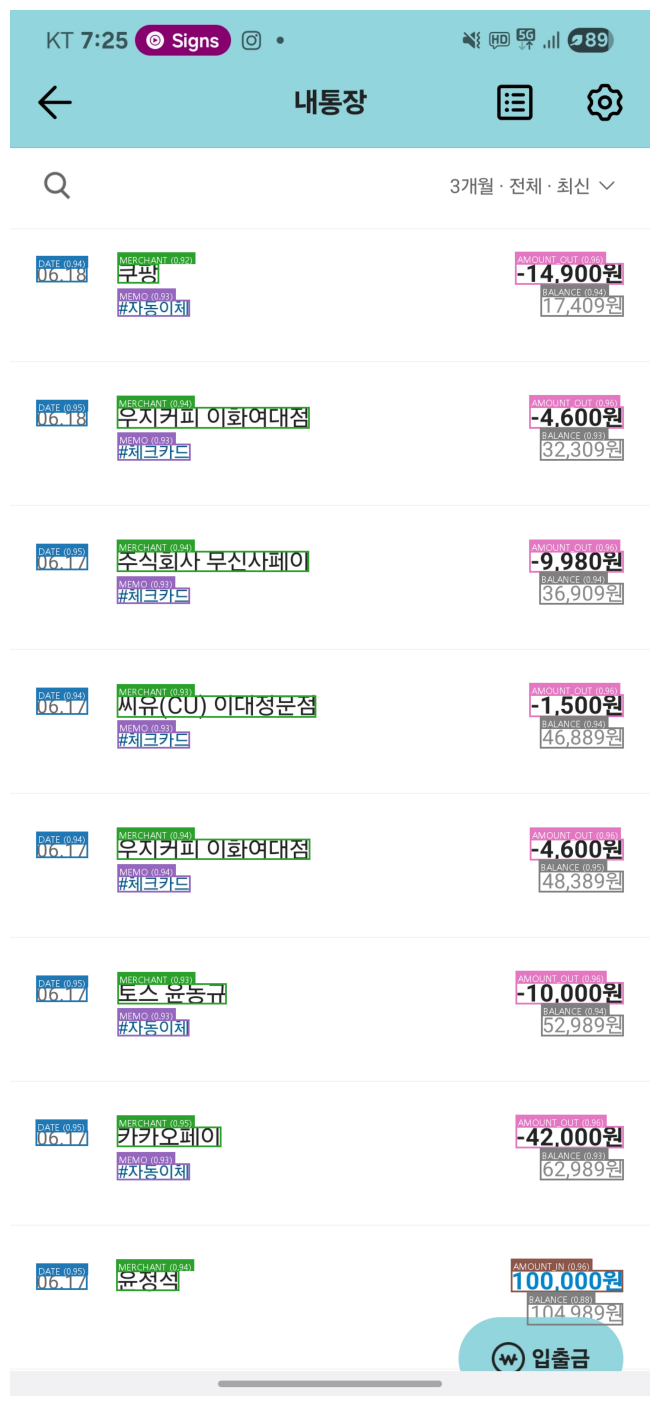


--- [1단계: 탐지] shinhan2.jpg ---


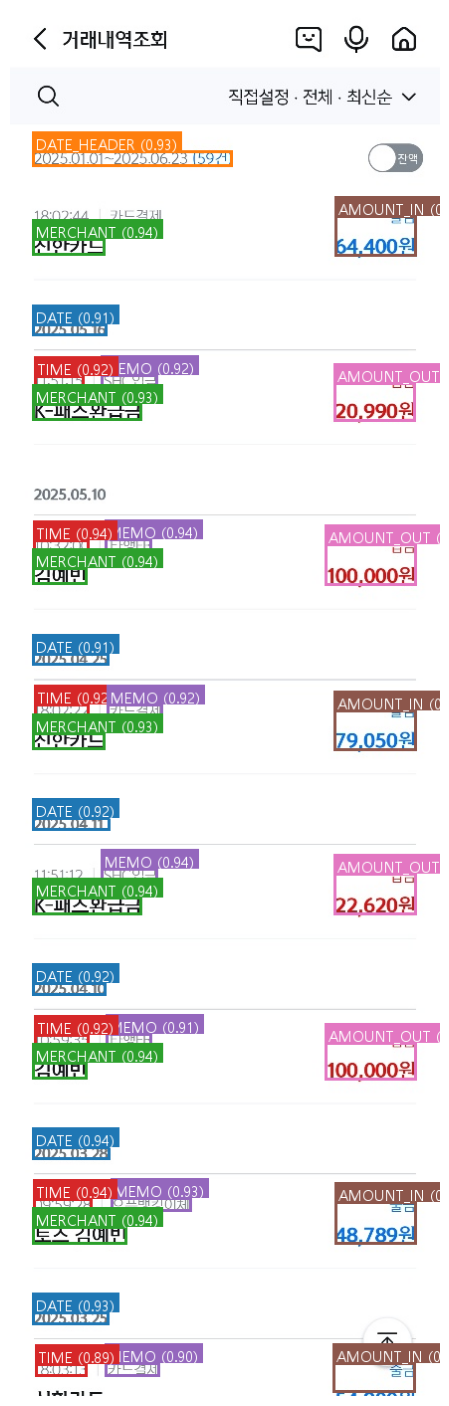


--- [1단계: 탐지] shinhan3.jpg ---


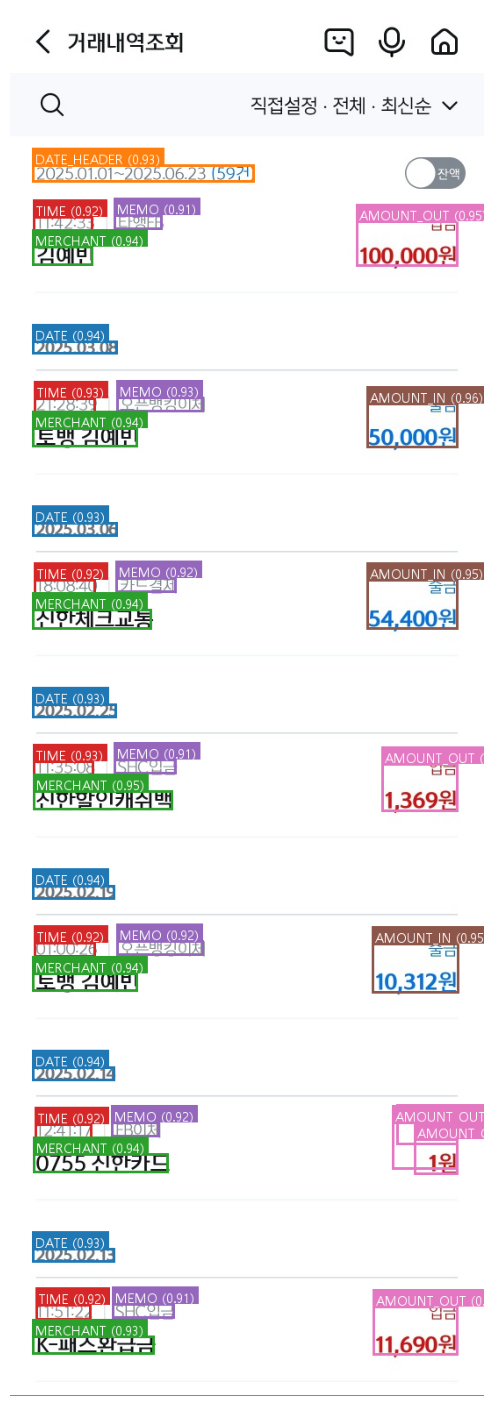


--- [1단계: 탐지] shinhan4.jpg ---


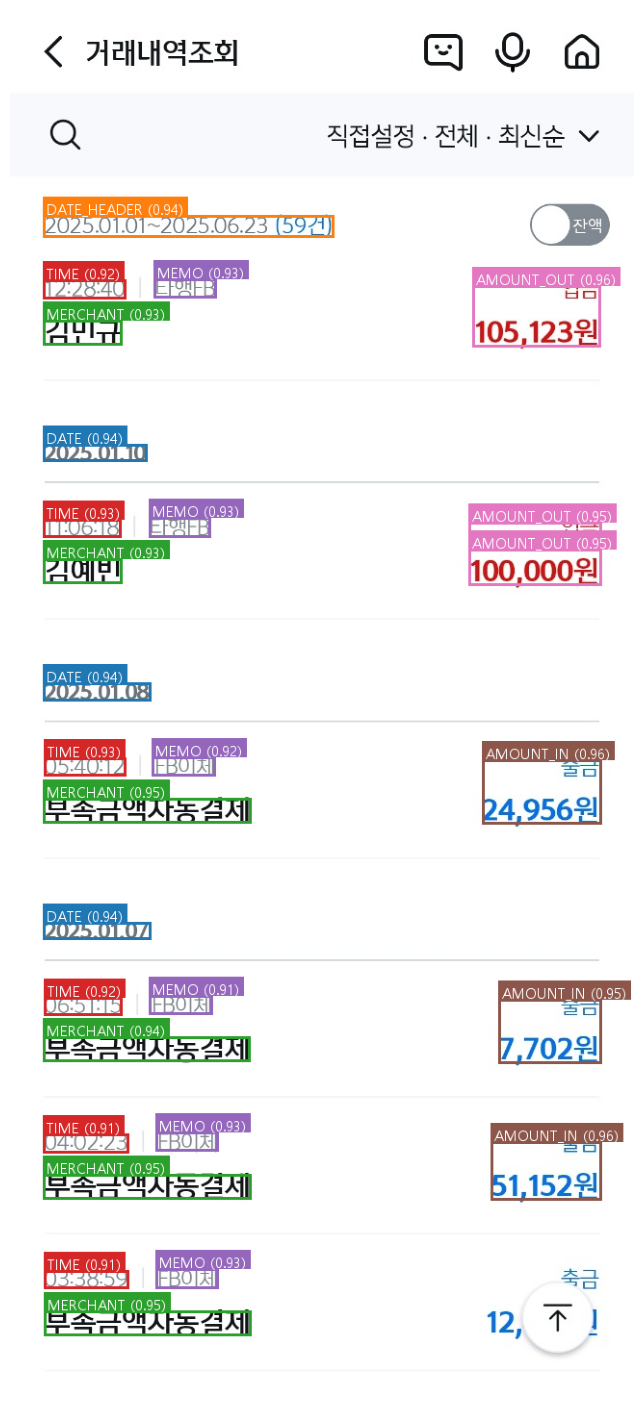

In [35]:
# --- 1단계: YOLO 영역 탐지 결과 확인 ---
test_image_files = glob.glob(os.path.join(TEST_IMAGE_DIR, '*.png')) + \
                   glob.glob(os.path.join(TEST_IMAGE_DIR, '*.jpg')) + \
                   glob.glob(os.path.join(TEST_IMAGE_DIR2, '*.png')) + \
                   glob.glob(os.path.join(TEST_IMAGE_DIR2, '*.jpg'))

if not test_image_files:
    print(f"오류: '{TEST_IMAGE_DIR}' 폴더에서 테스트 이미지를 찾을 수 없습니다.")
else:
    # 결과 저장 폴더 생성
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    for image_path in test_image_files:
        print(f"\n--- [1단계: 탐지] {os.path.basename(image_path)} ---")
        
        # 1. 객체 탐지 수행 (OCR 없음)
        detections, image = predictor.detect_only(image_path, conf_threshold=CONF_THRESHOLD)
        
        if detections is None:
            continue

        # 2. 탐지 결과 시각화
        result_image = predictor.draw_detections(image.copy(), detections)
        
        # 3. 노트북에 결과 이미지 바로 출력
        plt.figure(figsize=(9, 18))
        plt.imshow(result_image)
        plt.axis('off')
        plt.show()

In [36]:
# --- 2단계: OCR 적용 및 최종 결과 확인 ---
if not test_image_files:
    print(f"오류: 테스트 이미지가 없습니다. 이전 셀을 먼저 실행하세요.")
else:
    for image_path in test_image_files:
        print(f"\n--- [2단계: OCR+결과] {os.path.basename(image_path)} ---")
        
        # 1. 객체 탐지 수행
        detections, image = predictor.detect_only(image_path, conf_threshold=CONF_THRESHOLD)
        if detections is None:
            continue
            
        # 2. 탐지된 영역에 대해 OCR 수행
        predictions = predictor.run_ocr_on_detections(image, detections)

        # 3. 최종 결과 시각화
        result_image = predictor.draw_predictions(image.copy(), predictions)
        
        # 4. 노트북에 결과 이미지 바로 출력
        plt.figure(figsize=(12, 24))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title(f"Final OCR Result for {os.path.basename(image_path)}")
        plt.show()

        # 5. 시각화된 이미지 파일로 저장
        output_filename = "final_" + os.path.basename(image_path)
        result_image.save(os.path.join(OUTPUT_DIR, output_filename))
        print(f"최종 결과 이미지가 '{os.path.join(OUTPUT_DIR, output_filename)}'에 저장되었습니다.")

        # 6. 텍스트 요약 출력
        print("\n[텍스트 요약]")
        summary = defaultdict(list)
        for p in predictions:
            summary[p['label']].append(p['text'])
        
        for label, texts in sorted(summary.items()):
            print(f"- {label}: {', '.join(texts)}")
        print("-" * 50)


--- [2단계: OCR+결과] sc1.png ---


ValueError: too many values to unpack (expected 2)